# Capstone 3: Natural Language Processing on the Simpsons


**Objective 1:** Pick a set of text from various authors. Create a series of clusters and explore the results

**Objective 2:** Build a classifier which can identify the author

**The dataset:** For this project I used lines from The Simpsons TV series. The data can be found [here](https://www.kaggle.com/wcukierski/the-simpsons-by-the-data).  The dataset contains the characters, locations, episode details, and script lines for approximately 600 Simpsons episodes, dating back to 1989. For the purposes of this project I will only focus on the script lines and the character who spoke the line.

** What I learnt: ** Homer: "Every time I learn something new, a little of the old gets pushed out of my brain. Remember that time I took that wine making course and forgot how to drive?"

**Warning: ** Yes, there are going to be a lot of Simpsons quotes and references in here...

## Summary

(Note this will pull data from the notebook below - it cannot be run first)

The Simpsons dataset contains information he dataset contains 158,248 lines spoken in the series since it debuted in 1989. Over the years more than 7,000 characters have been introduced! Unfortunately for this project I had to ignore some of the smaller characters (sorry Sideshow Bob!).  I only keep the 13 characters with the most lines:

Homer Simpson, Marge Simpson, Bart Simpson, Lisa Simpson, C Montgomery Burns, Moe Szyslak, Seymour Skinner, Ned Flanders, Grampa Simpson, Milhouse Van Houten, Chief Wiggum, Krusty The Clown, Nelson Muntz

These characters account for 84,248 of the spoken lines. The lines were already relatively clean, with punctuation (except for dashes) stripped and everything changed into lowercase.
Defining stop words is the first decision point for this project. One option was to be aggressive by stripping out the most common words based on the top 5 or 10 per cent of most common words (calculated through the sum of a CountVectorizer). While this route has some appeal, it also inevitably strips away useful words. For example, it removes Homer and Marge’s names. Even though all the characters used these words, they are mostly used by Homer and Marge speaking to each other and are therefore valuable. Using a score (e.g. mean) from the tf-idf vectorizer is one possible way of dealing with this, but it was not attempted here. The other option was to iteratively adjust the stop words list, particularly based on the top 10 words (see below). Ultimately this method resulted in better results for the classifier.

While this dataset was a lot of fun to work with, the results were always going to be less that stellar.<br>
Max Power: Kids there’s three ways to do things -- the right way the wrong way and the Max Power way<br>
Bart: Isn’t that the wrong way?<br>
Max Power: Yeah, but faster<br>


First, it is unbalanced. Homer does the majority of talking.

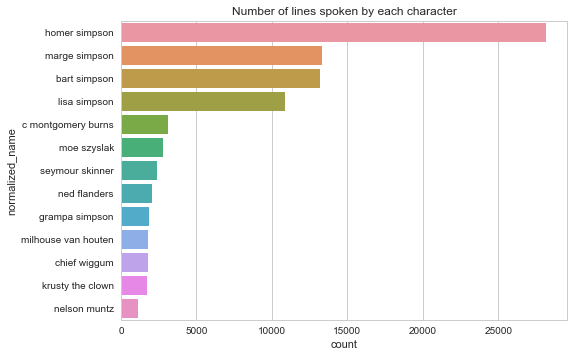

In [357]:
sns.set(style='whitegrid')
sns.countplot(y='normalized_name', data=simpsons,
              order = simpsons['normalized_name'].value_counts().index)
plt.title('Number of lines spoken by each character')
plt.show()

Secondly, the lines are short. On average there are 10 words per line. This does not give a lot of information to the classifier to identify a speaker.

Third, most of the words appear infrequently. About 45% of words are only used once, while	28% of the words are only used between two to four times in the entire series. While this is not uncommon for a corpus, the sheer width of topics covered in the series as well as the nuanced use of language (think of “hmm” versus “hmmmmm”) can exacerbate this. These observations are eventually excluded during the term frequency inverse document frequency (tf-idf) transformation as they add little value. Luckily the dataset remains large even after removing these words.


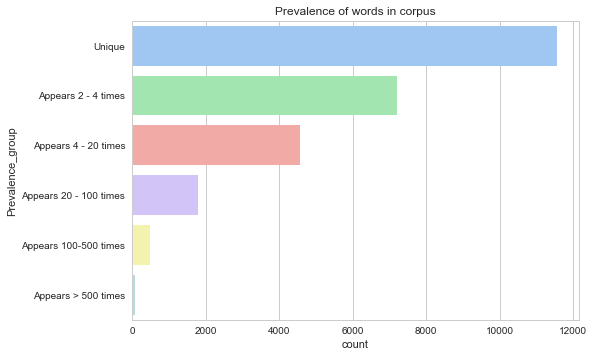

In [360]:
sns.set(style='whitegrid')
sns.countplot(y='Prevalence_group', data=topwords_df, palette='pastel')
plt.title('Prevalence of words in corpus')
plt.show()

Fourth, the characters have a lot fewer individual speaking traits than may have been expected. Below is the top ten words used by each character after cleaning the text (including creating lemmas) and removing stop words.

In [359]:
top.head(12)

,0,1,2,3,4,5,6,7,8,9,10
homer simpson,marge,hey,gon,good,little,boy,want,think,come,time,thing
marge simpson,homer,bart,homie,think,lisa,going,want,good,little,kid,time
bart simpson,dad,hey,mom,man,gon,want,come,think,really,guy,say
lisa simpson,dad,bart,mom,think,want,really,hey,gon,ive,time,little
c montgomery burns,smithers,simpson,yes,man,want,ive,good,time,say,make,excellent
moe szyslak,hey,homer,aint,gon,guy,moe,good,come,say,really,thing
seymour skinner,school,bart,simpson,mother,lisa,yes,child,good,student,ive,day
ned flanders,homer,little,hey,boy,simpson,ive,say,gon,think,good,lord
grampa simpson,son,old,time,day,good,boy,come,homer,want,gon,ive
milhouse van houten,bart,hey,lisa,say,dad,gon,mom,really,think,want,time


This also means that there is a high level of overlap between spoken words. Even for Ned Flanders, who has his own ‘didly’ way of speaking, there is a lot of overlap. However, note that this graph does not consider the number of times a word is spoken (Krusty says “hey” a lot, but Ned also says it from time to time). It is possible to have high overlap and still have strong classifying traits (e.g. Krusty’s “hey hey”). Therefore, the graph, combined with the table above, is only indicative that character speech patterns are not particularly distinct.

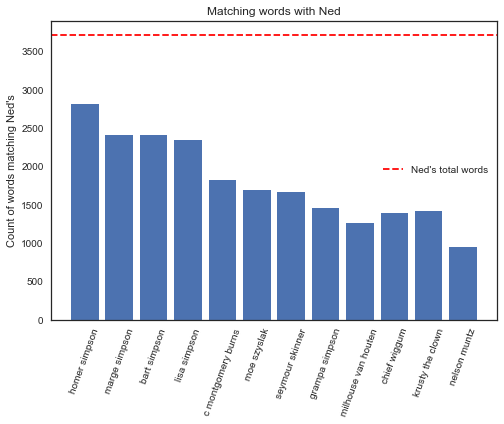

In [361]:
sns.set(style='white')
plt.bar(range(len(ned_overlaps)), list(ned_overlaps.values()), align='center')
plt.xticks(range(len(ned_overlaps)), list(ned_overlaps.keys()), rotation = 70)
plt.axhline(hline, label = "Ned\'s total words", color='r', linestyle = 'dashed')
plt.title("Matching words with Ned")
plt.ylabel("Count of words matching Ned's")
plt.legend()
plt.show()

## Krusty's house of Kmeans clusters

The clusters returned are not particularly useful. The first cluster uses a KMeans algorithm with 12 clusters. Changing the clusters size did not significantly affect performance. The text is transformed into a tf-idf matrix combined with a truncated singular value decomposition to reduce the feature set. However, to interpret the cluster it needs to be converted back into words rather than frequencies. The clusters also don’t necessarily respond to the character themselves. Below is the top ten words associated with each category (closest to the cluster centroid). While category 0 seems to correspond to Homer and 3 could be Lisa, the other clusters do not conform to any character. Instead it groups the clusters across common words. For example, Bart and Lisa’s speech are likely to be quite similar (e.g. ‘dad’ and ‘mom’) and therefore likely end up in the same cluster.


In [364]:
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :12]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: time come readin kid time get load going moes suitcase aww step soap slap lookin city hall
Cluster 1: mallet think might city hall university slap hello principal get load unknown piece readin true meaning lighter
Cluster 2: kid time city hall slap keep secret think might burly board game late lighter get load aww true meaning
Cluster 3: guess time guy who true meaning gon get fold imaginary city hall mr simpson happen kid time gypsy aww
Cluster 4: mr simpson kid time city hall lisa simpson step think might keep secret burly get load slap time come readin
Cluster 5: courage mallet fold man burn step piece think might guess time get load city hall late old folk
Cluster 6: wait minute wait hey gon get load readin think might kid time mr simpson step gee true meaning city hall waited
Cluster 7: step piece mallet screwing readin lot money pushy think might get load kid time gee lisa simpson
Cluster 8: fold aww city hall get along time come jessica think might board game burly fo

Next, a Mean Shift clustering algorithm was used. This algorithm is useful since it does not require the number of clusters as a hyperparameter (although it does introduce a new one – bandwidth). Only 4 clusters were allocated – highlighting some of the overlap discussed above. However, the results were still not particularly useful as shown below. 


In [368]:
print("Top terms per cluster:")

terms = vectorizer.get_feature_names()
for i in range(n_clusters_):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Top terms per cluster:
Cluster 0: kid time city hall mr simpson think might slap get load burly keep secret step lisa simpson
Cluster 1: he happy robbery mr simpson heated ban time come city hall step think might kid time
Cluster 2: ban mr simpson keep secret robbery kid time city hall time come fold bart could think might
Cluster 3: courage mallet fold step man burn think might piece city hall get load guess time
Cluster 4: wait minute wait mr simpson time come waited rolling wait til step kid time think might readin



Ultimately, clustering (especially using text) with a known ‘ground truth’ is unlikely going to provide more insight than simple descriptive statistics.


## Classifying

*Behold the legendary Esquilax! A horse with the head of a rabbit! And the body... of a rabbit!*

The classification models struggled to classify the characters, but still showed improvement over the naïve classification strategy (assuming all the lines are spoken by Homer gives a 32% accuracy). The models were also stable in cross validation. However, you will still definitely not make any bets with Fat Tony based on this model.


In [457]:
print(summary.round(2)) 

              Accuracy  Precision  Recall    f1
nb                0.39       0.62    0.13  0.13
sgd               0.38       0.26    0.19  0.21
sgd_reduced       0.35       0.24    0.17  0.18
nb_balanced       0.27       0.36    0.23  0.23
sgd_balanced      0.27       0.26    0.25  0.26


With only a few observations of the smaller characters (particularly in the test set), most of classifications were clustered around the Simpsons family. The table below shows the detailed confusion matrix of the Naive Bayes model.

In [479]:
nb_cross = pd.crosstab(y_test, y_hat, rownames = ['Actual y'], colnames=['Predicted'])
nb_cross.columns = ['Homer', 'Marge', 'Bart', 'Lisa', 'Mr Burns', 'Moe',' Seymour', 'Ned',
                'Grampa', 'Milhouse', 'Chief_Wiggum', 'Krusty']
nb_cross.head(12)

,Homer,Marge,Bart,Lisa,Mr Burns,Moe,Seymour,Ned,Grampa,Milhouse,Chief_Wiggum,Krusty
Actual y,,,,,,,,,,,,
0,6514,229,175,112,5,2,1,3,0,0,0,0
1,2487,679,84,70,1,1,0,0,0,0,0,0
2,2433,92,610,160,2,1,1,0,0,1,0,0
3,1990,102,225,401,2,0,3,0,0,0,0,0
4,669,38,12,12,49,0,0,0,0,0,0,0
5,637,29,23,6,0,7,0,0,0,0,0,0
6,460,49,40,41,0,0,7,0,0,0,0,0
7,412,63,22,8,0,0,1,8,0,0,0,0
8,420,22,16,7,0,2,0,0,2,0,0,0


Efforts to improve the model did not work. Balancing the dataset did not improve results. Reducing the feature set (using truncated singular value decomposition) also did not improve the results.

Conclusion
<br>
Homer: If you don't like your job, you don't strike! You just go in every day and do it really half assed. That's the American way. 

## Neural Networks: word2vec

Applying a word2vec model is the area that has the most potential. By including relationships of each word with its surrounding words in the sentence (here each spoken line) the model gains additional information (beyond extend the n_gram). Using this neural network approach, one can add and subtract vectors:
<br>
<br>
Bart + Lisa - Homer = ? 


In [409]:
model.wv.most_similar(positive=['lisa', 'bart'], negative=['homer'])

[('brother', 0.7877243161201477),
 ('sister', 0.767802894115448),
 ('strangling', 0.7545340061187744),
 ('chat', 0.7531639933586121),
 ('need', 0.7457866072654724),
 ('surprised', 0.7323021292686462),
 ('success', 0.7308045029640198),
 ('maggie', 0.7238890528678894),
 ('jessica', 0.7222068309783936),
 ('afraid', 0.7217413783073425)]

kid + Marge = ?

In [427]:
model.wv.most_similar(positive=['kid', 'marge'])

[('bored', 0.9029281139373779),
 ('jenda', 0.8810033798217773),
 ('mess', 0.8782816529273987),
 ('lose', 0.8697453141212463),
 ('follow', 0.868965744972229),
 ('fit', 0.8649928569793701),
 ('usually', 0.864076554775238),
 ('happens', 0.8619827628135681),
 ('outside', 0.8617384433746338),
 ('win', 0.8613463640213013)]

Find words that don't match:

In [424]:
model.wv.doesnt_match("homer, lisa, bart, moe".split())

'moe'

In [425]:
model.wv.doesnt_match("homer, beer, donut, milk".split())

'milk'

And we can test similarities. For example the model knows Bart and Lisa are strongly related. As are donuts to hmmmm-iness! 

In [436]:
model.wv.similarity("bart", "lisa")

0.9178787350736215

In [439]:
model.wv.similarity("donut", "hmmm")

0.743334891225236

## Conclusion

Worst. Model. Ever.

# The full Monty Burns: Full code

## Cleaning and processing the data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


In [332]:
# Read in data (errors are ignored, mistakes in data)
simpsons_full = pd.read_csv('simpsons_script_lines.csv', error_bad_lines=False)

b'Skipping line 8084: expected 13 fields, saw 20\nSkipping line 52607: expected 13 fields, saw 21\nSkipping line 59910: expected 13 fields, saw 21\n'
b'Skipping line 71801: expected 13 fields, saw 20\nSkipping line 73539: expected 13 fields, saw 21\nSkipping line 77230: expected 13 fields, saw 21\nSkipping line 78953: expected 13 fields, saw 21\nSkipping line 81138: expected 13 fields, saw 20\nSkipping line 86746: expected 13 fields, saw 22\nSkipping line 101154: expected 13 fields, saw 21\nSkipping line 115438: expected 13 fields, saw 20\nSkipping line 117573: expected 13 fields, saw 22\nSkipping line 130610: expected 13 fields, saw 22\n'
b'Skipping line 152970: expected 13 fields, saw 22\nSkipping line 153017: expected 13 fields, saw 20\nSkipping line 153018: expected 13 fields, saw 30\nSkipping line 154080: expected 13 fields, saw 20\nSkipping line 154082: expected 13 fields, saw 20\nSkipping line 154084: expected 13 fields, saw 20\nSkipping line 154086: expected 13 fields, saw 20\n

In [3]:
# Normalized_text has already stripped most punctuation (hyphens remain)

# Keep only normalized_text and character id            
simpsons = simpsons_full.loc[:, ['normalized_text', 'character_id']]

# Drop nan cases
print(len(simpsons.normalized_text))
simpsons.dropna(inplace=True)
simpsons.info()

158248
<class 'pandas.core.frame.DataFrame'>
Int64Index: 132062 entries, 0 to 158247
Data columns (total 2 columns):
normalized_text    132062 non-null object
character_id       132062 non-null object
dtypes: object(2)
memory usage: 3.0+ MB


In [4]:
# Trimming down the characters 
print('Characters recorded in Simpsons:', len(simpsons_full.character_id.unique()))
print()

# Make sure all character_ids are numerical
simpsons.loc[:, 'character_id'] = pd.to_numeric(simpsons.character_id)

# Keep only top characters, keep only index (id) and change to numeric
main_characters = simpsons.character_id.value_counts().index[0:13]
simpsons = simpsons.loc[simpsons['character_id'].isin(main_characters), :]
print(simpsons.info())

# Check who characters are
characters = pd.read_csv('simpsons_characters.csv')

# Add characters into dataframe
simpsons = pd.merge(simpsons, characters.loc[:, ['id', 'normalized_name']], how='left',
                                             left_on='character_id', right_on='id')

Characters recorded in Simpsons: 7184

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84248 entries, 1 to 158241
Data columns (total 2 columns):
normalized_text    84248 non-null object
character_id       84248 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB
None


In [5]:
def newID(num):
    if num==2.0:
        return 0
    elif num==1.0:
        return 1
    elif num==8.0:
        return 2
    elif num==9.0:
        return 3
    elif num==15.0:
        return 4
    elif num==17.0:
        return 5
    elif num==3.0:
        return 6
    elif num==11.0:
        return 7
    elif num==31.0:
        return 8
    elif num==25.0:
        return 9
    elif num==71.0:
        return 10
    elif num==139.0:
        return 11
    elif num==101.0:
        return 12
    else:
        return 13

# Re-index characters
simpsons['new_id']=simpsons.id.apply(lambda x: newID(x))

# Drop old ids
simpsons.drop(['character_id', 'id'], axis=1, inplace=True)


In [6]:
# Saving order for later
targets = list(simpsons['normalized_name'].value_counts().index)

# Calculating most words (no cleaning)

def mostwords(simpsons, targets):
    char_dict = {}
    for char in targets:
        count_vec = CountVectorizer(strip_accents='ascii', ngram_range=(1, 1),
                          analyzer='word',  stop_words='english')
        count_fit = count_vec.fit_transform(simpsons.loc[simpsons['normalized_name']==char, 'normalized_text'])
        sum_words = count_fit.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
        top10 = sorted(words_freq, key = lambda x: x[1], reverse=True)[0:11]
        topwords = []
        for top in top10:
            topwords.append(top[0])
        char_dict[char]=topwords
    return char_dict 
                                        
top = pd.DataFrame.from_dict(mostwords(simpsons, targets), orient='index')
top.head(15)

,0,1,2,3,4,5,6,7,8,9,10
homer simpson,oh,im,marge,dont,just,like,know,youre,right,thats,hey
marge simpson,homer,oh,im,dont,just,like,bart,know,youre,homie,thats
bart simpson,dad,im,hey,dont,oh,just,like,youre,mom,know,got
lisa simpson,dad,bart,im,mom,dont,just,oh,like,youre,know,thats
c montgomery burns,smithers,oh,im,simpson,yes,like,dont,youre,ill,just,man
moe szyslak,hey,uh,im,homer,oh,yeah,just,thats,like,got,dont
seymour skinner,im,oh,school,bart,just,simpson,dont,lisa,yes,uh,mother
ned flanders,homer,oh,im,just,like,dont,thats,know,got,little,uh
grampa simpson,im,oh,got,dont,youre,just,ill,thats,son,know,old
milhouse van houten,bart,im,like,oh,hey,just,got,dont,lisa,know,uh


This is going to be difficult. Even once stop words are removed, there aren't many clear indicators (or catch phrases) to unique identify the speaker. Mr Burns generally speaks to Smithers, Lisa and Bart to their dad, Marge to Homer (but so does Moe and Ned), and Krusty always starts with 'hey' - but these may still not be prevelant enough to create a good classifier.

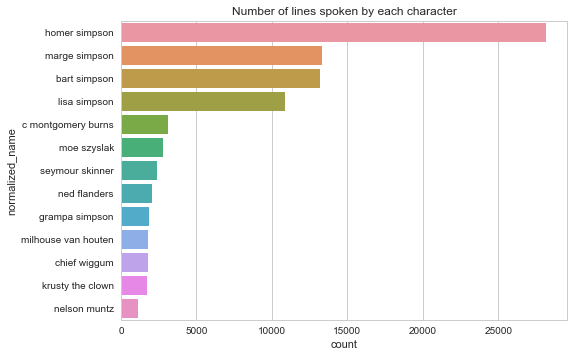

In [7]:
sns.set(style='whitegrid')
sns.countplot(y='normalized_name', data=simpsons,
              order = simpsons['normalized_name'].value_counts().index)
plt.title('Number of lines spoken by each character')
plt.show()

In [51]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Basic stopwords list
stopWords = stopwords.words('english')
stopped = []
for w in stopWords:
    stopped.append(re.sub(r"\'", '', w))
# Add some specific words
stopped.append('dont')
stopped.append('like')
stopped.append('got')
stopped.append('know')
stopped.append('ill')
stopped.append('look')
stopped.append('right')
stopped.append('yeah')
stopped.append('okay')
stopped.append('thats')
stopped.append('let')
stopped.append('need')

# Using count word frequency for more aggresive stop words list

# word_dict = {}
# count_vec = CountVectorizer(strip_accents='ascii', ngram_range=(1, 1), 
#                                 analyzer='word',  stop_words='english')
# count_fit = count_vec.fit_transform(simpsons.loc[:, 'normalized_text'])
# sum_words = count_fit.sum(axis=0)
# words_freq = [(word, sum_words[0, idx]) for word, idx in count_vec.vocabulary_.items()] 
# most_used_words = sorted(words_freq, key = lambda x: x[1],
#                          reverse=True)[0:int(len(count_vec.vocabulary_.items())*0.05)]
# for word in most_used_words:
#     stopped.append(word[0])

def textcleaner(text):
    ''' Takes in raw unformatted text and strips punctuation, removes whitespace,
    strips numbers, tokenizes and stems.
    Returns string of processed text to be used into text vectorizer
    '''
    # Removes '-' and '--' in text
    cleaner = re.sub(r'-+',' ',text)
    # Tokenize
    cleaner = word_tokenize(cleaner)
    lems = WordNetLemmatizer()
    clean = []
    for w in cleaner:
        # filter out stopwords
        if w not in stopped:
            # filter out short words
            if len(w)>2:
                # Lemma 
                clean.append(lems.lemmatize(w))
    return ' '.join(clean)


In [387]:
#Create X and y
simpsons['clean_text'] = simpsons.normalized_text.apply(lambda x: textcleaner(x))

#Create y
y = simpsons.loc[:, 'new_id']

In [324]:
# Calculating most words (with cleaning)

def mostwords(simpsons, targets):
    char_dict = {}
    for char in targets:
        count_vec = CountVectorizer(strip_accents='ascii', ngram_range=(1, 1),
                          analyzer='word',  stop_words='english')
        count_fit = count_vec.fit_transform(simpsons.loc[simpsons['normalized_name']==char, 'clean_text'])
        sum_words = count_fit.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
        top10 = sorted(words_freq, key = lambda x: x[1], reverse=True)[0:11]
        topwords = []
        for top in top10:
            topwords.append(top[0])
        char_dict[char]=topwords
    return char_dict 

top = pd.DataFrame.from_dict(mostwords(simpsons, targets), orient='index')
top.head(12)

,0,1,2,3,4,5,6,7,8,9,10
homer simpson,marge,hey,gon,good,little,boy,want,think,come,time,thing
marge simpson,homer,bart,homie,think,lisa,going,want,good,little,kid,time
bart simpson,dad,hey,mom,man,gon,want,come,think,really,guy,say
lisa simpson,dad,bart,mom,think,want,really,hey,gon,ive,time,little
c montgomery burns,smithers,simpson,yes,man,want,ive,good,time,say,make,excellent
moe szyslak,hey,homer,aint,gon,guy,moe,good,come,say,really,thing
seymour skinner,school,bart,simpson,mother,lisa,yes,child,good,student,ive,day
ned flanders,homer,little,hey,boy,simpson,ive,say,gon,think,good,lord
grampa simpson,son,old,time,day,good,boy,come,homer,want,gon,ive
milhouse van houten,bart,hey,lisa,say,dad,gon,mom,really,think,want,time


The cleaned up version shows a bit more promise. The top word count for each character now shows some sensible patters (e.g. Homer often talking to Marge, the kids to Homer, Principal Skinner talks about school). However, there is still a lot of overlap (e.g. want, look, yeah), so the predictive power may still be low.

In [215]:
# Showing why this is going to be difficult...
# Speech is highly concentrated and overlaps between characters (even for Ned...)

# Create instance
count_vec = CountVectorizer(strip_accents='ascii', ngram_range=(1, 1), 
                                analyzer='word',  stop_words='english')
# Fit data
count_fit = count_vec.fit_transform(simpsons.loc[:, 'clean_text'])
#Sum columns
sum_words = count_fit.sum(axis=0)
# Match sums to column names (each word)
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vec.vocabulary_.items()] 
# Sort on count number
most_used_words = sorted(words_freq, key = lambda x: x[1],
                         reverse=True)
# Create df of words and counts
topwords_df = pd.DataFrame(most_used_words, columns = ['word', 'word_count'])
# topwords_df['quantiles']=pd.qcut(topwords_df.loc[:, 'wcount'], 4,
#                                  duplicates='drop', labels=False)

def grouper(num):
    ''' Sorts values into groups'''
    if num==1:
        return 'Unique'
    elif (num >1 and num<5):
        return 'Appears 2 - 4 times'
    elif (num>=4 and num<20):
        return 'Appears 4 - 20 times'
    elif (num>=20 and num<100):
        return 'Appears 20 - 100 times'
    elif (num>=100 and num<500):
        return 'Appears 100-500 times'
    else:
        return 'Appears > 500 times'

# Create groups for graph    
topwords_df['Prevalence_group'] = topwords_df.word_count.apply(lambda x: grouper(x)).astype('category')

# Order the categorical
topwords_df['Prevalence_group'].cat.reorder_categories(["Unique", "Appears 2 - 4 times",
                                                        "Appears 4 - 20 times", "Appears 20 - 100 times",
                                                        "Appears 100-500 times", "Appears > 500 times"],
                                                       inplace=True)

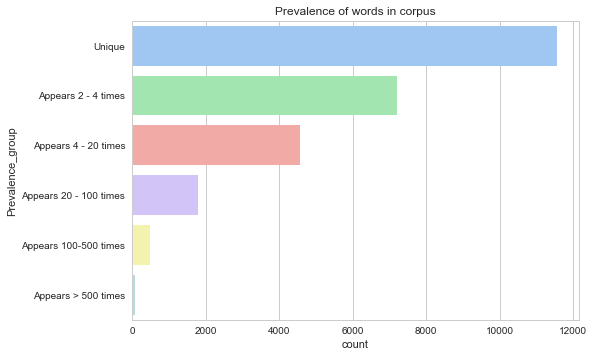

In [216]:
# Finally! Showing this on a graph
sns.set(style='whitegrid')
sns.countplot(y='Prevalence_group', data=topwords_df, palette='pastel')
plt.title('Prevalence of words in corpus')
plt.show()

In [309]:
# Speech overlap between Ned and Homer
def wordsOverlap(simpsons, char):
    ''' Returns list of unique words by character'''
    temp = simpsons.loc[simpsons['normalized_name']==char,
                        'clean_text'].apply(lambda x: x.split(' '))
    allwords_list = []
    for i in temp:
        allwords_list += i
    #print("{} of words spoken by {}".format(len(allwords_list), char))
    distinct_list = np.unique(np.array(allwords_list))
    #print("{} of distinct words spoken by {}".format(len(distinct_list), char))
    return distinct_list

# Iterating to get list of unique words by character
char_dict = {}
for char in targets:
    char_dict[char] = wordsOverlap(simpsons, char) 
# Creating dict of overlapping words    
overlaps = {}
for char in targets:
    for other in targets:
        overlaps[char, other] = len(np.intersect1d(char_dict[char][0], char_dict[other][0]))

In [318]:
# Overlaps for Ned
ned_overlaps = {}
for char in targets:
    ned_overlaps[char] = len(np.intersect1d(char_dict['ned flanders'][0], char_dict[char][0]))
hline = ned_overlaps['ned flanders']
del ned_overlaps['ned flanders']

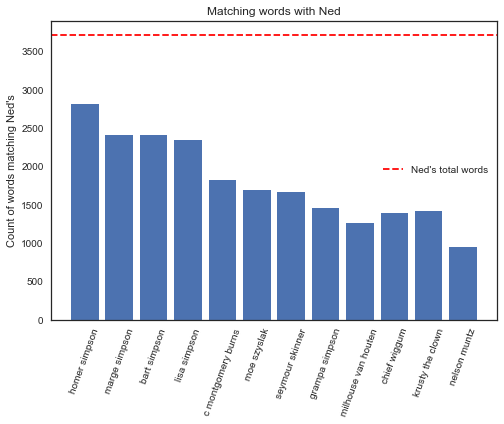

In [322]:
sns.set(style='white')
plt.bar(range(len(ned_overlaps)), list(ned_overlaps.values()), align='center')
plt.xticks(range(len(ned_overlaps)), list(ned_overlaps.keys()), rotation = 70)
plt.axhline(hline, label = "Ned\'s total words", color='r', linestyle = 'dashed')
plt.title("Matching words with Ned")
plt.ylabel("Count of words matching Ned's")
plt.legend()
plt.show()

In [458]:
from sklearn import model_selection

X = simpsons.loc[:, 'clean_text']
y = simpsons.loc[:, 'new_id']

# Splitting into train and test before vectorizing
Xs_train, Xs_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25,
                                                                        random_state=42,
                                                                       stratify=y) 

In [459]:
# Vectorizing on training data
vectorizer = TfidfVectorizer(min_df=6, strip_accents='ascii', analyzer='word', lowercase=True,
                             ngram_range=(1,2), max_df=0.8, sublinear_tf=True)
X_train = vectorizer.fit_transform(Xs_train)
print(X_train.shape)

# Apply model to test data
X_test = vectorizer.transform(Xs_test)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(63186, 7549)


In [13]:
# indices = np.argsort(vectorizer.idf_)[::-1]
# features = vectorizer.get_feature_names()
# top_n = 100
# top_features = [features[i] for i in indices[:top_n]]
# print(top_features)

## Krusty's fun house of K-lusters

### Kmeans

In [362]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import normalize
from sklearn import decomposition
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn import metrics


true_k = 13

svd = decomposition.TruncatedSVD(true_k)
lsa = make_pipeline(svd, Normalizer(copy=False))

X_train_lsa = lsa.fit_transform(X_train)

km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100)
km.fit(X_train_lsa)

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))


print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_train, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(y_train, km.labels_))
#print("Adjusted Rand-Index: %.3f"
#      % metrics.adjusted_rand_score(y_train, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_train_lsa, km.labels_, sample_size=1000))


Explained variance of the SVD step: 5%
Homogeneity: 0.037
Completeness: 0.035
Silhouette Coefficient: 0.335


In [363]:
# Main terms per cluster
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

print("Top terms per cluster:")

terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :12]:
        print(' %s' % terms[ind], end='')
    print()

Top terms per cluster:
Cluster 0: time come readin kid time get load going moes suitcase aww step soap slap lookin city hall
Cluster 1: mallet think might city hall university slap hello principal get load unknown piece readin true meaning lighter
Cluster 2: kid time city hall slap keep secret think might burly board game late lighter get load aww true meaning
Cluster 3: guess time guy who true meaning gon get fold imaginary city hall mr simpson happen kid time gypsy aww
Cluster 4: mr simpson kid time city hall lisa simpson step think might keep secret burly get load slap time come readin
Cluster 5: courage mallet fold man burn step piece think might guess time get load city hall late old folk
Cluster 6: wait minute wait hey gon get load readin think might kid time mr simpson step gee true meaning city hall waited
Cluster 7: step piece mallet screwing readin lot money pushy think might get load kid time gee lisa simpson
Cluster 8: fold aww city hall get along time come jessica think mi

In [16]:
# How close are labels to actual characters
y_hat = km.predict(X_train_lsa)
cross = pd.crosstab(y_hat, y_train)
print(cross)
print('Accuracy: %0.3f' % metrics.accuracy_score(y_train, y_hat))


new_id    0     1     2     3     4    5    6    7    8    9    10   11   12
row_0                                                                       
0       3931  1526  1160  1001   385  258  230  208  220  170  183  168  101
1       1841   640   874   731   185  111  140   88   88  135   85   81   58
2        846   554   336   303   163   98  119  157   51   43   98   40   13
3       1061   437   465   286   133  107   67   55   55   45   57   78   37
4       8717  3881  4018  3080  1152  737  877  567  713  497  553  539  345
5        403   428   124   516     6    5  105   15   16  170   12   12   27
6        839   364   295   280    83  123   51   80   61   38   72   72   34
7        174    38   671   860     8    5    5    3    8   40    2   10   13
8       1827   943  1023   806   155  169  160  133   97  122  102  118  164
9        752    66   521   169    11  157   13   41   35   57   73  109   48
10       528    53   275   107     4  149    8   21   22   29   85   54   17

In [17]:
# Effectiveness in dealing with new data
X_test_lsa = lsa.transform(X_test)
y_hat = km.predict(X_test_lsa)
cross = pd.crosstab(y_hat, y_test)
print(cross)
print('\n')
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_test, y_hat))
print("Completeness: %0.3f" % metrics.completeness_score(y_test, y_hat))
#print("Adjusted Rand-Index: %.3f"
#      % metrics.adjusted_rand_score(y_train, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_test_lsa, y_hat, sample_size=1000))


new_id    0     1     2     3    4    5    6    7    8    9    10   11   12
row_0                                                                      
0       1281   520   379   334  132   83   60   63   55   60   59   48   43
1        609   237   302   220   68   44   49   35   27   38   30   31   18
2        292   189   100    86   55   30   39   62   21   15   41   23    9
3        334   125   176    99   36   31   34   22   20   19   27   29   13
4       3045  1338  1328  1099  380  256  303  203  256  174  208  196  112
5        148   164    35   186    1    2   30    4    7   55    3    3    6
6        278   136   104    80   32   32   23   20   25   19   21   20    4
7         56     9   236   272    0    2    1    1    0   10    0    3    2
8        508   254   319   257   53   58   45   30   30   30   20   22   49
9        239    20   186    46    3   46    4   15    5   14   18   38   16
10       167    25   100    32    1   59    1    2   11   14   17   14    9
11        84

### Mean shift

In [365]:
from sklearn.cluster import MeanShift, estimate_bandwidth


# Here we set the bandwidth.
bandwidth = estimate_bandwidth(X_train_lsa, quantile=0.3, n_samples=1000)
print(bandwidth)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_lsa)

# Extract cluster assignments for each data point.
labels = ms.labels_
# Count our clusters
n_clusters_ = len(np.unique(labels))
print("Number of estimated clusters: {}".format(n_clusters_))

# Relative scoring
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_train, ms.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(y_train, ms.labels_))
#print("Adjusted Rand-Index: %.3f"
#      % metrics.adjusted_rand_score(y_train, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_train_lsa, ms.labels_, sample_size=1000))

print()


0.8547191408350245
Number of estimated clusters: 5
Homogeneity: 0.026
Completeness: 0.109
Silhouette Coefficient: 0.274



In [366]:
# Finding words associated with each cluster
original_space_centroids = svd.inverse_transform(ms.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

print("Top terms per cluster:")

terms = vectorizer.get_feature_names()
for i in range(n_clusters_):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()
    


Top terms per cluster:
Cluster 0: kid time city hall mr simpson think might slap get load burly keep secret step lisa simpson
Cluster 1: he happy robbery mr simpson heated ban time come city hall step think might kid time
Cluster 2: ban mr simpson keep secret robbery kid time city hall time come fold bart could think might
Cluster 3: courage mallet fold step man burn think might piece city hall get load guess time
Cluster 4: wait minute wait mr simpson time come waited rolling wait til step kid time think might readin


In [20]:
print('\n Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,ms.labels_))


 Comparing the assigned categories to the ones in the data:
col_0       0     1    2    3    4    5    6
new_id                                      
0       15181  4012  400  180  534  523  292
1        6610  2558  456   37   52  168   84
2        6519  2013  121  676  277  176  116
3        5053  1371  524  858  106  156  100
4        1791   417    6    8    4   11  103
5        1253   625    7    4  151   55   12
6        1323   271   98    5    8   15   73
7         974   479   16    5   22   27   19
8        1080   253   16    8   22   18    9
9         828   236  177   40   29   26   13
10        878   315   12    2   83   48    9
11        873   304   12   10   55   27    9
12        627   151   27   14   19    9   12


In [21]:
# Effectiveness in dealing with new data
X_test_lsa = lsa.transform(X_test)
y_hat = km.predict(X_test_lsa)
cross = pd.crosstab(y_hat, y_test)
print(cross)
print('\n')
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_test, y_hat))
print("Completeness: %0.3f" % metrics.completeness_score(y_test, y_hat))
#print("Adjusted Rand-Index: %.3f"
#      % metrics.adjusted_rand_score(y_train, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_test_lsa, y_hat, sample_size=1000))

new_id    0     1     2     3    4    5    6    7    8    9    10   11   12
row_0                                                                      
0       1281   520   379   334  132   83   60   63   55   60   59   48   43
1        609   237   302   220   68   44   49   35   27   38   30   31   18
2        292   189   100    86   55   30   39   62   21   15   41   23    9
3        334   125   176    99   36   31   34   22   20   19   27   29   13
4       3045  1338  1328  1099  380  256  303  203  256  174  208  196  112
5        148   164    35   186    1    2   30    4    7   55    3    3    6
6        278   136   104    80   32   32   23   20   25   19   21   20    4
7         56     9   236   272    0    2    1    1    0   10    0    3    2
8        508   254   319   257   53   58   45   30   30   30   20   22   49
9        239    20   186    46    3   46    4   15    5   14   18   38   16
10       167    25   100    32    1   59    1    2   11   14   17   14    9
11        84

# Character classification 

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

## The baseline: TF-IDF and Naive Bayes

In [460]:
# Repeating vectorizing here

# Vectorizing on training data
vectorizer = TfidfVectorizer(min_df=6, strip_accents='ascii', analyzer='word', lowercase=True,
                             ngram_range=(1,3), max_df=0.9)
X_train = vectorizer.fit_transform(Xs_train)
print(X_train.shape)

# Apply model to test data
X_test = vectorizer.transform(Xs_test)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(63186, 7640)


In [461]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

#Initialize and fit
nb = MultinomialNB()
nb.fit(X_train, y_train)
print(" Train accuracy is: %0.3f" % nb.score(X_train, y_train))

# Apply to testing data
y_hat = nb.predict(X_test)


# Showing model performance
print("Accuracy is: %0.3f" % nb.score(X_test, y_test))
print(metrics.classification_report(y_test, y_hat, target_names=targets))

cross = pd.crosstab(y_test, y_hat)
print(cross)


# Saving summary stats
compareModels = {}
compareModels['nb'] = [metrics.accuracy_score(y_test, y_hat),
                     metrics.precision_score(y_test, y_hat, average = 'macro'),
                     metrics.recall_score(y_test, y_hat, average = 'macro'),
                     metrics.f1_score(y_test, y_hat, average = 'macro')] 

 Train accuracy is: 0.448
Accuracy is: 0.395


C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

      homer simpson       0.38      0.93      0.53      7041
      marge simpson       0.50      0.20      0.29      3322
       bart simpson       0.46      0.18      0.26      3300
       lisa simpson       0.46      0.15      0.22      2723
 c montgomery burns       0.83      0.06      0.12       780
        moe szyslak       0.44      0.01      0.02       702
    seymour skinner       0.50      0.01      0.02       597
       ned flanders       0.73      0.02      0.03       514
     grampa simpson       1.00      0.00      0.01       469
milhouse van houten       0.00      0.00      0.00       449
       chief wiggum       0.80      0.01      0.02       449
   krusty the clown       1.00      0.00      0.01       430
       nelson muntz       0.97      0.12      0.21       286

        avg / total       0.49      0.39      0.30     21062

col_0     0    1    2    3   4   5   6   7   8   10  11  12
new_id                

C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


This model performs better than the default strategey of assuming Homer says all the lines (which gives accuracy of 32%). However, at 40% it is not particularly powerful predictor. Much of it seems to stem from the imbalance of the dataset. The model biases towards Homer (see column 0) and there are almost no observations available for the lesser characters.   

In [349]:
from sklearn import model_selection

#Stratified CV
count = 0
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True)
for train_index, test_index in skf.split(X, y):
    Xc_train, Xc_test = X.iloc[train_index], X.iloc[test_index]
    ycv_train, ycv_test = y.iloc[train_index], y.iloc[test_index]
    vectorizer = TfidfVectorizer(min_df=6, strip_accents='ascii', analyzer='word', lowercase=True,
                             ngram_range=(1,3), max_df=0.9)
    Xcv_train = vectorizer.fit_transform(Xc_train)
    Xcv_test = vectorizer.transform(Xc_test)
    nb = MultinomialNB()
    nb.fit(Xcv_train, ycv_train)
    print(" Train accuracy is: %0.3f" % nb.score(Xcv_train, ycv_train))
    # Showing model performance
    count += 1
    print('Accuracy for fold {} is {}'.format(count, nb.score(Xcv_test, ycv_test)))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


 Train accuracy is: 0.447
Accuracy for fold 1 is 0.39575175032633203
 Train accuracy is: 0.448
Accuracy for fold 2 is 0.3968310486024568
 Train accuracy is: 0.449
Accuracy for fold 3 is 0.39246290801186945
 Train accuracy is: 0.448
Accuracy for fold 4 is 0.4010209532854514
 Train accuracy is: 0.446
Accuracy for fold 5 is 0.4002137005817405


### Stochastic gradient descent

In [354]:
from sklearn.linear_model import SGDClassifier

sgdc = SGDClassifier(loss = 'hinge')
sgdc.fit(X_train, y_train)
print(" Train accuracy is: %0.3f" % sgdc.score(X_train, y_train))


# Still on test
y_hat = sgdc.predict(X_test)

# Showing model performance
print("Accuracy is: %0.3f" % sgdc.score(X_test, y_test))
print(metrics.classification_report(y_test, y_hat, target_names=targets))

cross = pd.crosstab(y_test, y_hat)
print(cross)

# Saving summary stats
compareModels['sgd'] = [metrics.accuracy_score(y_test, y_hat),
                     metrics.precision_score(y_test, y_hat, average = 'macro'),
                     metrics.recall_score(y_test, y_hat, average = 'macro'),
                     metrics.f1_score(y_test, y_hat, average = 'macro')] 

 Train accuracy is: 0.496
Accuracy is: 0.381
                     precision    recall  f1-score   support

      homer simpson       0.42      0.70      0.53      7041
      marge simpson       0.38      0.29      0.33      3322
       bart simpson       0.35      0.24      0.28      3300
       lisa simpson       0.33      0.28      0.30      2723
 c montgomery burns       0.38      0.25      0.30       780
        moe szyslak       0.23      0.11      0.14       702
    seymour skinner       0.25      0.15      0.19       597
       ned flanders       0.26      0.13      0.17       514
     grampa simpson       0.09      0.02      0.04       469
milhouse van houten       0.06      0.03      0.04       449
       chief wiggum       0.21      0.11      0.14       449
   krusty the clown       0.21      0.07      0.10       430
       nelson muntz       0.25      0.14      0.18       286

        avg / total       0.35      0.38      0.35     21062

col_0     0    1    2    3    4   5  

In [369]:
#Stratified CV
count = 0
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True)
for train_index, test_index in skf.split(X, y):
    Xc_train, Xc_test = X.iloc[train_index], X.iloc[test_index]
    ycv_train, ycv_test = y.iloc[train_index], y.iloc[test_index]
    vectorizer = TfidfVectorizer(min_df=6, strip_accents='ascii', analyzer='word', lowercase=True,
                             ngram_range=(1,3), max_df=0.9)
    Xcv_train = vectorizer.fit_transform(Xc_train)
    Xcv_test = vectorizer.transform(Xc_test)
    sgd = SGDClassifier(loss = 'hinge')
    sgd.fit(Xcv_train, ycv_train)
    print(" Train accuracy is: %0.3f" % sgd.score(Xcv_train, ycv_train))
    # Showing model performance
    count += 1
    print('Accuracy for fold {} is {}'.format(count, sgd.score(Xcv_test, ycv_test)))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


 Train accuracy is: 0.499
Accuracy for fold 1 is 0.3835291325501365
 Train accuracy is: 0.497
Accuracy for fold 2 is 0.38258857041125155
 Train accuracy is: 0.492
Accuracy for fold 3 is 0.3800593471810089
 Train accuracy is: 0.496
Accuracy for fold 4 is 0.37994895233572745
 Train accuracy is: 0.497
Accuracy for fold 5 is 0.38673869167754954


## Reducing the feature set

In [355]:
from sklearn import decomposition
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier


# Some feature reduction
# Only on SGD - nb requires positive inputs

svd= decomposition.TruncatedSVD(1000)
lsa = make_pipeline(svd, Normalizer(copy=False))
#Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train)
X_test_lsa = lsa.transform(X_test)

sgdc = SGDClassifier(loss = 'hinge')
sgdc.fit(X_train_lsa, y_train)
print("Train accuracy is: %0.3f" % sgdc.score(X_train_lsa, y_train))


# Still on test
y_hat = sgdc.predict(X_test_lsa)

# Showing model performance
print("Test accuracy is: %0.3f" % sgdc.score(X_test_lsa, y_test))
print(metrics.classification_report(y_test, y_hat, target_names=targets))

cross = pd.crosstab(y_test, y_hat)
print(cross)

# Saving summary stats
compareModels['sgd_reduced'] = [metrics.accuracy_score(y_test, y_hat),
                     metrics.precision_score(y_test, y_hat, average = 'macro'),
                     metrics.recall_score(y_test, y_hat, average = 'macro'),
                     metrics.f1_score(y_test, y_hat, average = 'macro')] 

Train accuracy is: 0.374
Test accuracy is: 0.346
                     precision    recall  f1-score   support

      homer simpson       0.41      0.68      0.51      7041
      marge simpson       0.47      0.22      0.29      3322
       bart simpson       0.30      0.24      0.26      3300
       lisa simpson       0.42      0.19      0.26      2723
 c montgomery burns       0.48      0.18      0.26       780
        moe szyslak       0.08      0.13      0.10       702
    seymour skinner       0.30      0.15      0.20       597
       ned flanders       0.09      0.12      0.10       514
     grampa simpson       0.08      0.01      0.01       469
milhouse van houten       0.01      0.00      0.00       449
       chief wiggum       0.17      0.09      0.12       449
   krusty the clown       0.04      0.13      0.06       430
       nelson muntz       0.28      0.13      0.18       286

        avg / total       0.35      0.35      0.32     21062

col_0     0    1    2    3    4  

## Using a balanced dataset

In [453]:
# Under and oversampling to create balanced data set

df_list = []
for char in targets:
    samples = 0
    # Identify Simpson family and limit to 4000 obs
    if len(simpsons.loc[simpsons['normalized_name']==char, 'normalized_name'])>5000:
        samples=2000
        # Slices for particular character and samples
        df_list.append(simpsons.loc[simpsons['normalized_name']==char, :].sample(samples, random_state=13))
    else:
        # For all other characters return all observations
        df_list.append(simpsons.loc[simpsons['normalized_name']==char, :])


simpsons_balanced = pd.concat(df_list)
simpsons_balanced.info()

X = simpsons_balanced.loc[:, 'clean_text']
y = simpsons_balanced.loc[:, 'new_id']

#Splitting into train and test before vectorizing
Xs_train, Xs_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.40,
                                                                      random_state=13,
                                                                      stratify=y) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26709 entries, 3510 to 82377
Data columns (total 4 columns):
normalized_text    26709 non-null object
normalized_name    26709 non-null object
new_id             26709 non-null int64
clean_text         26709 non-null object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


### Naive Bayes

In [454]:
# Vectorizing on training data
vectorizer = TfidfVectorizer(min_df=3, strip_accents='ascii', analyzer='word', lowercase=True,
                             ngram_range=(1,2), max_df=0.8)
X_train = vectorizer.fit_transform(Xs_train)
print(X_train.shape)


# Apply model to test data
X_test = vectorizer.transform(Xs_test)


#Initialize and fit
nb = MultinomialNB()
nb.fit(X_train, y_train)
print(" Train accuracy is: %0.3f" % nb.score(X_train, y_train))

# Apply to testing data
y_hat = nb.predict(X_test)


# Showing model performance
print("Test accuracy is: %0.3f" % nb.score(X_test, y_test))
print(metrics.classification_report(y_test, y_hat, target_names=targets))

cross = pd.crosstab(y_test, y_hat)
print(cross)

# Saving summary stats
compareModels['nb_balanced'] = [metrics.accuracy_score(y_test, y_hat),
                     metrics.precision_score(y_test, y_hat, average = 'macro'),
                     metrics.recall_score(y_test, y_hat, average = 'macro'),
                     metrics.f1_score(y_test, y_hat, average = 'macro')]

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(16025, 5414)
 Train accuracy is: 0.487
Test accuracy is: 0.268
                     precision    recall  f1-score   support

      homer simpson       0.23      0.08      0.12       800
      marge simpson       0.27      0.13      0.18       800
       bart simpson       0.29      0.12      0.17       800
       lisa simpson       0.32      0.17      0.22       800
 c montgomery burns       0.23      0.71      0.35      1248
        moe szyslak       0.22      0.54      0.31      1124
    seymour skinner       0.32      0.35      0.33       956
       ned flanders       0.43      0.25      0.32       823
     grampa simpson       0.31      0.11      0.16       750
milhouse van houten       0.36      0.12      0.18       719
       chief wiggum       0.42      0.15      0.22       718
   krusty the clown       0.42      0.12      0.19       688
       nelson muntz       0.93      0.14      0.24       458

        avg / total       0.33      0.27      0.24     10684

col_0   0    1   2

### Stochastic gradient descent

In [455]:
from sklearn.linear_model import SGDClassifier

sgdc = SGDClassifier(loss = 'hinge')
sgdc.fit(X_train, y_train)
print(" Train accuracy is: %0.3f" % sgdc.score(X_train, y_train))


# Still on test
y_hat = sgdc.predict(X_test)

# Showing model performance
print("Accuracy is: %0.3f" % sgdc.score(X_test, y_test))
print(metrics.classification_report(y_test, y_hat, target_names=targets))

cross = pd.crosstab(y_test, y_hat)
print(cross)

compareModels['sgd_balanced'] = [metrics.accuracy_score(y_test, y_hat),
                     metrics.precision_score(y_test, y_hat, average = 'macro'),
                     metrics.recall_score(y_test, y_hat, average = 'macro'),
                     metrics.f1_score(y_test, y_hat, average = 'macro')]

 Train accuracy is: 0.614
Accuracy is: 0.268
                     precision    recall  f1-score   support

      homer simpson       0.19      0.12      0.15       800
      marge simpson       0.23      0.19      0.21       800
       bart simpson       0.18      0.15      0.17       800
       lisa simpson       0.24      0.23      0.23       800
 c montgomery burns       0.41      0.41      0.41      1248
        moe szyslak       0.31      0.34      0.33      1124
    seymour skinner       0.34      0.36      0.35       956
       ned flanders       0.34      0.31      0.32       823
     grampa simpson       0.24      0.21      0.22       750
milhouse van houten       0.14      0.30      0.20       719
       chief wiggum       0.29      0.27      0.28       718
   krusty the clown       0.29      0.24      0.26       688
       nelson muntz       0.23      0.18      0.20       458

        avg / total       0.27      0.27      0.27     10684

col_0   0    1    2    3    4    5   

Using a balanced dataset requires a large loss of information, which eventually harms the predictive ability of the model. Overfitting also becomes more of a threat, e.g. the SGD model accuracy falls from 60% in the training data to less than 30% in testing. However, even using feature reduction (see below) doesn't seem to help on this.

Note that while the model performs poorly, it has a much better performance against the default model (here always choosing Homer will only give a 7% accuracy). 

In [310]:
svd= decomposition.TruncatedSVD(1000)
lsa = make_pipeline(svd, Normalizer(copy=False))
#Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train)
X_test_lsa = lsa.transform(X_test)

sgdc = SGDClassifier(loss = 'hinge')
sgdc.fit(X_train_lsa, y_train)
print("Train accuracy is: %0.3f" % sgdc.score(X_train_lsa, y_train))


# Still on test
y_hat = sgdc.predict(X_test_lsa)

# Showing model performance
print("Test accuracy is: %0.3f" % sgdc.score(X_test_lsa, y_test))
print(metrics.classification_report(y_test, y_hat, target_names=targets))

cross = pd.crosstab(y_test, y_hat)
print(cross)

Train accuracy is: 0.329
Test accuracy is: 0.231
                     precision    recall  f1-score   support

      homer simpson       0.29      0.10      0.14       800
      marge simpson       0.12      0.49      0.19       800
       bart simpson       0.13      0.20      0.16       800
       lisa simpson       0.31      0.17      0.22       800
 c montgomery burns       0.51      0.33      0.40      1248
        moe szyslak       0.36      0.22      0.28      1124
    seymour skinner       0.50      0.25      0.34       956
       ned flanders       0.46      0.22      0.30       823
     grampa simpson       0.15      0.20      0.17       750
milhouse van houten       0.16      0.22      0.19       719
       chief wiggum       0.34      0.18      0.24       718
   krusty the clown       0.42      0.14      0.21       688
       nelson muntz       0.15      0.21      0.17       458

        avg / total       0.32      0.23      0.24     10684

col_0   0    1    2    3    4    

In [456]:
summary = pd.DataFrame.from_dict(compareModels, orient='index')
summary.columns = ['Accuracy', 'Precision', 'Recall', 'f1']
print(summary.round(2))   

              Accuracy  Precision  Recall    f1
nb                0.39       0.62    0.13  0.13
sgd               0.38       0.26    0.19  0.21
sgd_reduced       0.35       0.24    0.17  0.18
nb_balanced       0.27       0.36    0.23  0.23
sgd_balanced      0.27       0.26    0.25  0.26


# Neural Networks: word2vec

In [389]:
# Xs_train is currently a series containing one string per row, change to list of words
X_wordlist = Xs_train.apply(lambda x: x.split(sep=' '))

In [390]:
len(X_wordlist)

63186

In [392]:
import gensim
from gensim.models import word2vec

model = word2vec.Word2Vec(
    X_wordlist,
    workers=4,     # Number of threads to run in parallel (if your computer does parallel processing).
    #min_count=1,  # Minimum word count threshold.
    window=6,      # Number of words around target word to consider.
    #sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    size=300,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)

print('done!')



done!


In [393]:
w2v = dict(zip(model.wv.index2word, model.wv.vectors))

In [394]:
len(w2v)

5910

In [408]:
# List of words in model.
vocab = model.wv.vocab.keys()


model.wv.most_similar(positive=['lisa', 'bart'], negative=['homer'])

[('brother', 0.7877243161201477),
 ('sister', 0.767802894115448),
 ('strangling', 0.7545340061187744),
 ('chat', 0.7531639933586121),
 ('need', 0.7457866072654724),
 ('surprised', 0.7323021292686462),
 ('success', 0.7308045029640198),
 ('maggie', 0.7238890528678894),
 ('jessica', 0.7222068309783936),
 ('afraid', 0.7217413783073425)]

In [429]:
model.wv.most_similar(positive=['kid', 'marge'])

[('bored', 0.9029281139373779),
 ('jenda', 0.8810033798217773),
 ('mess', 0.8782816529273987),
 ('lose', 0.8697453141212463),
 ('follow', 0.868965744972229),
 ('fit', 0.8649928569793701),
 ('usually', 0.864076554775238),
 ('happens', 0.8619827628135681),
 ('outside', 0.8617384433746338),
 ('win', 0.8613463640213013)]

In [422]:
model.wv.doesnt_match("homer, lisa, bart, moe".split())


'moe'

In [423]:
model.wv.doesnt_match("homer, beer, donut, milk".split())


'milk'

In [419]:
model.wv.similarity("bart", "lisa")

0.9178787350736215

In [420]:
model.wv.similarity("homer", "stop")

0.4768412655008446

In [434]:
model.wv.similarity("donut", "hmmm")

0.743334891225236

## Something for next time: Build word2vec as featureset for Naive Bayes

In [ ]:
# Build sklearn-compatible transformer

# Average word vectors

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.items())))
        
    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [448]:
meancount = MeanEmbeddingVectorizer(w2v)

In [450]:
mtrx = meancount.fit(X_wordlist, ys_train)

In [89]:
X_transform = meancount.transform(X_wordlist)

In [ ]:
# This doesn't quite work yet. The X and y lengths don't match up

from sklearn.pipeline import Pipeline
sgd_w2v = Pipeline([
    ('word2vec vectorizer', MeanEmbeddingVectorizer(w2v)),
     ('sgd', SGDClassifier(loss = 'hinge'))
])

sgd_w2v.fit(w2v, ys_train)
print("Train accuracy is: %0.3f" % sgd_w2v.score(w2v, ys_train))


# Still on test
#y_hat = sgdc.predict(X_test_lsa)

      

In [69]:
len(w2v)

3343

In [452]:
len(ys_train)

67402

In [66]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.items().next())

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])